In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

# Libraries to be used for model evaluation and data scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Libraries to be used for the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# It is used to turn off warnings.
import warnings
warnings.filterwarnings('ignore')

# Tensorflow Warning Blocking
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#### Data Preparation

In [2]:
df = pd.read_csv("dataset.csv")
df.head()
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [3]:
df.columns = ["Month", "Passengers"]

In [4]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [5]:
df.tail()

#there is missing data

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [6]:
df.shape

(145, 2)

In [7]:
df.dtypes
# The month variable type should be date, but object. Its type should be corrected.

Month          object
Passengers    float64
dtype: object

In [8]:
df = df[:144]
# We will leave out the missing value at the end.

In [9]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [10]:
df["Month"]=pd.to_datetime(df["Month"])
# We change the type of the month variable to date.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [12]:
print("Minimum Tarih:", df["Month"].min())
print("Maksimum Tarih:", df["Month"].max())

Minimum Tarih: 1949-01-01 00:00:00
Maksimum Tarih: 1960-12-01 00:00:00


In [13]:
df.index = df["Month"]

In [14]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [15]:
df.drop("Month", axis=1, inplace=True)

In [16]:
result_df = df.copy()

In [17]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


#### Data Visualization

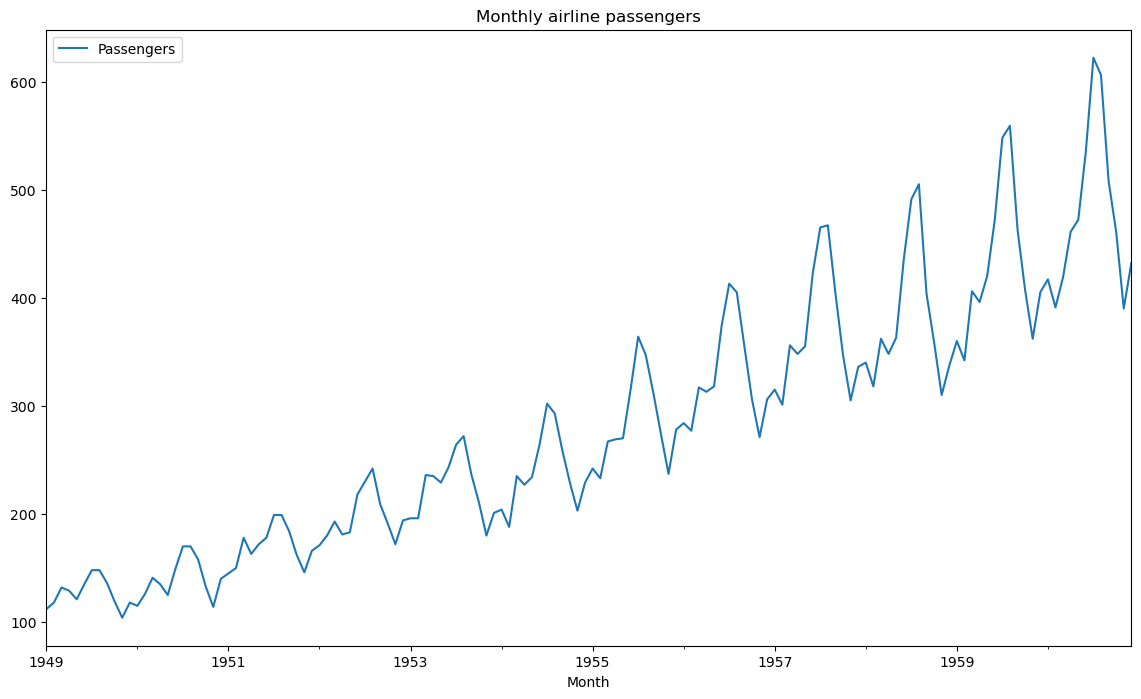

In [18]:
df.plot(figsize=(14,8), title="Monthly airline passengers");

When we examine the series, we observe an increasing trend. There is also seasonality and the series is not stationary.
Our data is in pandas dataframe format. Before starting the modeling process, we need to convert this data into a numpy array.

In [19]:
data = df["Passengers"].values

In [20]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [21]:
type(data[0:5])

numpy.ndarray

In [22]:
type(data[0])

numpy.float64

Currently float64. But the type we will use will be float32. It is the 32-bit format commonly used when transmitting to a neural network, so we will convert it to float32.

In [23]:
data = data.astype("float32")

In [24]:
type(data[0])

numpy.float32

We need to make a size adjustment before inserting the data into the model.

In [25]:
data.shape

(144,)

We will perform a conversion to (144, 1) dimension.

In [26]:
data = data.reshape(-1, 1)

In [27]:
data.shape

(144, 1)

It is now in a single dimension and consists of 144 observations.

In [28]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [29]:
train, test, position = split_data(data, 0.33)
print(train.shape, test.shape)

(96, 1) (48, 1)


In [30]:
scaler_train = MinMaxScaler(feature_range= (0, 1))
train = scaler_train.fit_transform(train)

scaler_test = MinMaxScaler(feature_range= (0, 1))
test = scaler_test.fit_transform(test)

In [31]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [32]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [33]:

def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])

    return np.array(X), np.array(Y)

In [34]:
lookback=1

X_train, y_train = create_features(train, 1) 

X_test, y_test = create_features(test, 1)

In [35]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [36]:
X_train = np.reshape(X_train,(X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0], 1, X_test.shape[1]))
y_train =  y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [37]:
print(X_train.shape, X_test.shape, y_test.shape)

(95, 1, 1) (47, 1, 1) (47, 1)


#### Modelling

In [38]:
model = Sequential()
model.add(SimpleRNN(units=50,
                    activation="relu",
                    input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Setting Optimization and Evaluation Metrics

In [40]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [41]:
callbacks =  [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"),
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min",
                              save_best_only=True, save_weights_only=False, verbose=1)]

In [42]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
66/95 [===================>..........] - ETA: 0s - loss: 0.0152  
Epoch 1: val_loss improved from inf to 0.03396, saving model to mymodel.h5
95/95 [==============================] - 1s 3ms/step - loss: 0.0194 - val_loss: 0.0340
Epoch 2/50
61/95 [==================>...........] - ETA: 0s - loss: 0.0220
Epoch 2: val_loss improved from 0.03396 to 0.02458, saving model to mymodel.h5
95/95 [==============================] - 0s 1ms/step - loss: 0.0231 - val_loss: 0.0246
Epoch 3/50
68/95 [====================>.........] - ETA: 0s - loss: 0.0135
Epoch 3: val_loss improved from 0.02458 to 0.02315, saving model to mymodel.h5
95/95 [==============================] - 0s 1ms/step - loss: 0.0158 - val_loss: 0.0232
Epoch 4/50
63/95 [==================>...........] - ETA: 0s - loss: 0.0104
Epoch 4: val_loss improved from 0.02315 to 0.02215, saving model to mymodel.h5
95/95 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0222
Epoch 5/50
61/95 [==================>.

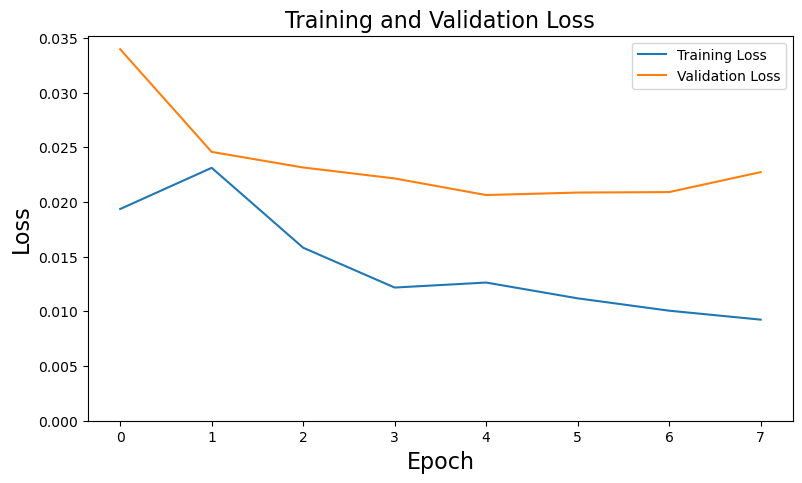

In [43]:
# Loss

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

#### Model Evaluation

In [44]:
loss = model.evaluate(X_test, y_test, batch_size=1)
print("\nTest loss: %.1f%%" % (100.0 * loss))

47/47 [==============================] - 0s 630us/step - loss: 0.0227

Test loss: 2.3%


In [45]:
train_predict = model.predict(X_train)   
test_predict = model.predict(X_test) 

2/2 [==============================] - 0s 0s/step


In [46]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [47]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [48]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [49]:
test_rmse= np.sqrt(mean_squared_error(y_test, test_predict))

In [50]:
print(f"Train RMSE: {train_rmse}")  # 24 birim
print(f"Train RMSE: {test_rmse}")  

Train RMSE: 27.107288360595703
Train RMSE: 48.396644592285156


In [51]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [52]:
train_prediction_df = result_df[lookback:position]  
train_prediction_df["Predicted"] = train_predict  
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,138.850876
1949-03-01,132.0,144.035980
1949-04-01,129.0,156.592819
1949-05-01,121.0,153.902054
1949-06-01,135.0,146.726730


In [53]:
test_prediction_df = result_df[position+lookback:]  
test_prediction_df["Predicted"] = test_predict 
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,342.103119
1957-03-01,356.0,330.106445
1957-04-01,348.0,378.876740
1957-05-01,355.0,371.701416
1957-06-01,422.0,377.979797


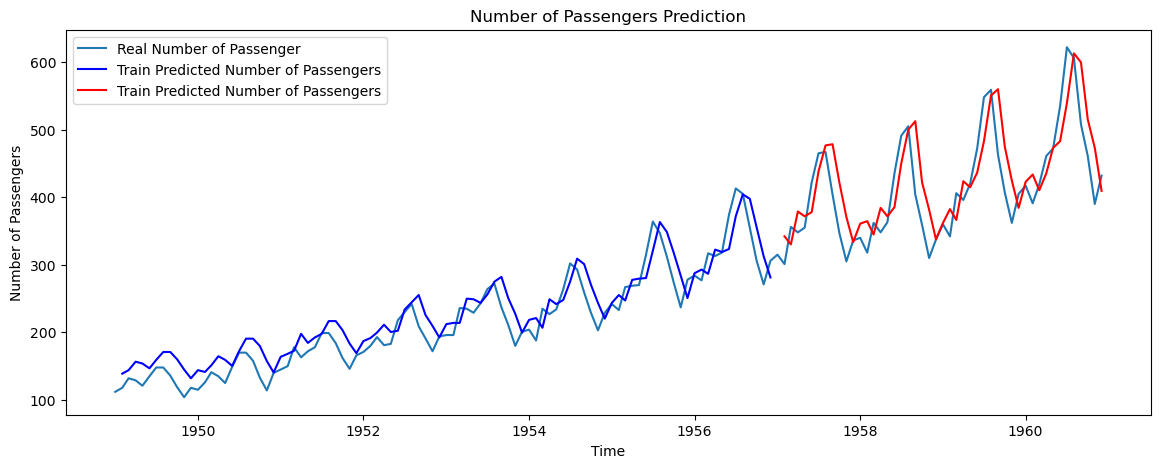

In [54]:
plt.figure(figsize=(14,5))
plt.plot(result_df, label = 'Real Number of Passenger')
plt.plot(train_prediction_df["Predicted"], color = "blue", label = "Train Predicted Number of Passengers")
plt.plot(test_prediction_df["Predicted"], color = "red", label = "Train Predicted Number of Passengers")
plt.title("Number of Passengers Prediction")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()